<a href="https://colab.research.google.com/github/MoritaHiroki87/ZZ_MachineLearningNote/blob/master/DLHO_Chainer%E5%85%A5%E9%96%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6 Chainer入門（分類）
## 6章で覚えときたいこと

### LinearとFunctionsの違い
L（Linear）が線形変換、引数あり。   
F（Functions）が非線形変換、引数なし。   

### データの分割
基本、pandasのDFで読み込んで、ilocで分割して、データ形式を整えていく。   
データ形式の要件は、

 - 入力変数や教師データがNumpyで定義されているか
 - 分類の場合、ラベルが0から始まっているか
 - 入力変数が float32、教師データが回帰の場合 float32、分類の場合 int32 で定義されているか
 
というかんじ。 

## 6.1 Chainerの基礎

In [296]:
import chainer
chainer.__version__

'5.4.0'

### 6.1.1 リンクの定義

In [0]:
import chainer.links as L

In [0]:
# fc (fully-connected layerの略)
fc = L.Linear(3, 2)

In [299]:
fc.W

variable W([[-0.4447606 , -0.42441568,  0.15621749],
            [ 0.36207277,  0.4326906 , -0.5702473 ]])

In [300]:
fc.b

variable b([0., 0.])

### 6.1.2 乱数のシードを固定して再現性を確保
これ疑問。   
ここの固定ってのはなんなのか？　このjupyternotebookを開いていたら？　同じDocker上で作業していたら？　ということは同じリソースに触るのか複数人で？　まあええねんけどな。

In [0]:
import numpy as np
np.random.seed(3)

In [302]:
fc.W
fc.b

variable b([0., 0.])

### 6.1.3 線形変換の値を計算しよう
forwardの処理。   
なお、Chainerで計算するにあたって、要素の型はfloat32にする必要がある。

In [303]:
 # 基本行列として作る
x = np.array([[1, 2, 3]], dtype=np.float32)

print(type(x), x.shape)

<class 'numpy.ndarray'> (1, 3)


In [304]:
u = fc(x)
u

variable([[-0.8249395 , -0.48328793]])

### 6.1.4 非線形変換の値を計算しよう
これは発火関数とか。   
relu関数は負の数の場合０になって、正の数の場合そのままのやつ。


In [305]:
import chainer.functions as F
z = F.relu(u)
z

variable([[0., 0.]])

## 6.2 練習問題

In [306]:
# 入力
np.random.seed(3)

x = np.array([[1, 2, 3]], dtype=np.float32)

fc1 = L.Linear(3, 2)
fc2 = L.Linear(2, 1)

# 実装
u1 = fc1(x)
z1 = F.relu(u1)
y = fc2(z1)
y

variable([[-0.09968679]])

## 6.3 損失関数の値を計算しよう

In [307]:
t = np.array([[3]], 'f')
print(type(t[0, 0]))

<class 'numpy.float32'>


In [308]:
loss = F.mean_squared_error(t, y)
loss

variable(9.608059)

## 6.4 Chainerでクラス分類

### 6.4.1 データの準備

In [0]:
# ワインのデータがどこにあるんか分からんからイリス使う
import pandas as pd
from sklearn.datasets import load_iris

x, t = load_iris(return_X_y=True)



#### 入力データとターゲットを切り分け


In [0]:
# すでにnumpyのデータになってるので下記必要ないが、一番悩んだところなのでかく
# df = pd.read_csv('data/wine_class.csv')

# t = df.iloc[:, 0]
# x = df.iloc[:, 1:]

#### Cnainerで扱えるデータ形式へ変換
扱えるデータ形式は

 - 入力変数や教師データがNumpyで定義されているか
 - 分類の場合、ラベルが0から始まっているか
 - 入力変数が float32、教師データが回帰の場合 float32、分類の場合 int32 で定義されているか

って感じだ！

##### Numpyに変換

In [0]:
# type(x)
# -> pandas.core.frame.DataFrame
# x = x.values

##### 分類で使うラベルを０から始める

In [0]:
# t.min()
# -> 1
# t.max()
# -> 3

# t = t.values - 1

##### データ型を32bitに変換

In [313]:
# データ型を変更

t.dtype

dtype('int64')

In [0]:
# 32bitに変換
x = x.astype('float32')
t = t.astype('int32')

#### Chaienrで使うデータセットの形式
入力ベクトル、ターゲットスカラのタプルをリストにしたもの。   
なお、``list(zip(x, t))``は``TupleDataset(x, t)``と同じデータ形式。

In [315]:
dataset = list(zip(x, t))
print(type(dataset))
print(type(dataset[-1]))
print(dataset[-1])

<class 'list'>
<class 'tuple'>
(array([5.9, 3. , 5.1, 1.8], dtype=float32), 2)


In [316]:
from chainer.datasets import TupleDataset
dataset2 = TupleDataset(x, t)
print(type(dataset2))
print(type(dataset2[-1]))
print(dataset2[-1])

<class 'chainer.datasets.tuple_dataset.TupleDataset'>
<class 'tuple'>
(array([5.9, 3. , 5.1, 1.8], dtype=float32), 2)


#### 訓練データと検証データの分割


In [0]:
n_train = int(len(dataset) * 0.7)

train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=1)

In [318]:
print(len(train), len(test))

105 45


### 6.4.2 モデルを定義

#### モデルの定義とインスタンス化

In [0]:
class NN(chainer.Chain):
    
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)
            
    # 順伝播
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [0]:
np.random.seed(1)

In [0]:
nn = NN()

#### 損失関数をネットワークに登録する

In [0]:
model = L.Classifier(nn)

### 6.4.3 最適化関数を定義

In [0]:
optimizer = chainer.optimizers.SGD().setup(model)

### 6.4.4 Iteratorの定義（つまづきポイント！）

Iteratorではバッチサイズを決めることができる。ミニバッチを使うんだよ、わかったね...。

In [0]:
batchsize = 15

In [0]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

### 6.4.5 Updaterの定義

UpdaterはoptimizerとIteratorをラップ？して、Optimizerの設定やデバイスの設定を行えます！

In [0]:
from chainer import training
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

### 6.4.6 Trainerとextensionsの設定
トレーナはアップデータとエクステンションをまとめたやつ

In [0]:
from chainer.training import extensions

In [0]:
epoch = 150

In [0]:
# trainerの宣言
trainer = training.Trainer(updater, (epoch, 'epoch'))

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

# 学習の経過をtrainerのoutで指定したフォルダにlogというファイル名で記録する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごと(trigger)に、trainデータに対するlossと、testデータに対するloss、経過時間（elapsed_time）を標準出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

### 6.4.7 学習の実行

In [330]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.314286       0.377778                  1.56547     1.20309               0.0188358     
2           0.342857       0.377778                  1.20016     1.05926               0.0373144     
3           0.352381       0.333333                  1.05471     0.997503              0.058365      
4           0.447619       0.555556                  0.985642    0.964277              0.0776756     
5           0.609524       0.555556                  0.945412    0.938647              0.0952964     
6           0.6            0.6                       0.912429    0.913035              0.11603       
7           0.666667       0.666667                  0.887258    0.888623              0.133061      
8           0.657143       0.711111                  0.862501    0.863581              0.152763      
9           0.72381        0.755556                  0.838       0.84016            

### 6.4.8 結果の確認
グラフの目盛りがでんなあ！！！！

In [0]:
import json

In [332]:
!ls result/log

result/log


In [0]:
with open('result/log')as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

In [334]:
results.head(5)

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,0.018836,1,7,0.314286,1.565474,0.377778,1.203087
1,0.037314,2,14,0.342857,1.200163,0.377778,1.059256
2,0.058365,3,21,0.352381,1.054712,0.333333,0.997503
3,0.077676,4,28,0.447619,0.985642,0.555556,0.964277
4,0.095296,5,35,0.609524,0.945412,0.555556,0.938647


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

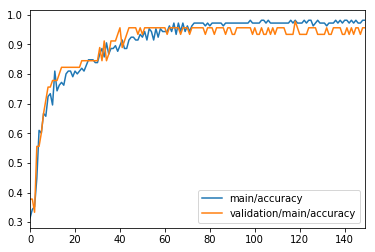

In [336]:
# accuracy（精度）を表示
res = results[['main/accuracy', 'validation/main/accuracy']].plot()

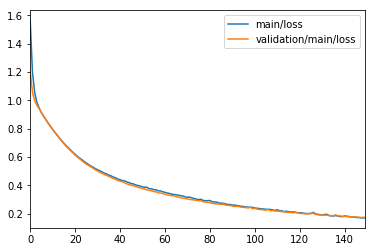

In [337]:
# loss（損失関数）を表示
results[['main/loss', 'validation/main/loss']].plot()

### 6.4.9 学習済みモデルを保存

### 6.4.10 学習済みモデルを使用した推論